# Analisi dati del CRC
Questo notebook è parzialmente basato sui notebook di Antonio Iuliano: https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/CRCQuality.ipynb?ref_type=heads e https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/DisplayCRCData.ipynb?ref_type=heads

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.modeling import models, fitting

In [2]:
data_file = "./data/CRC-4 LNGS 28-04-2025 21-51-35.txt"
crc_ver = '2.10'

## Lettura dei dati
cf. https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/CRCQuality.ipynb?ref_type=heads

In [3]:
def convertdata(xnumber,verbose = False):
 '''converte i dati dal CRC in binario, con l'informazione dei piani accesi
    xnumber: numero del piano;
    verbose: se True, stampa a schermo i numeri convertiti per controllo
 '''
 nplanes = 4
 planes=[] #lista di destinazione
 for iplane in range(nplanes-1,-1,-1): #ciclo da 3 a 0
  #convertiamo i numeri da esadecimale, per ognuno dei 4 piani
  planecode = int(xnumber[2*iplane:2*iplane+2],16)
  if (verbose):
   #stampiamo le informazioni dei piani
   print(format(planecode,"#08b")) #08b è il formato binario, con gli zeri a monte lasciati per vedere i piani spenti
  planes.append(format(planecode,"#08b")) #aggiungiamo il piano alla lista di uscita
 return planes 

In [4]:
muondata = pd.read_csv(data_file,header=None,sep=" ",dtype=str)
if crc_ver == '2.4':
    muondata.columns = ["Event Number","YZview","XZview","Time"] #first Y, then X
elif crc_ver == '2.10':
    ### NB: Usare la linea seguente per i dati acquisiti con l'app >=v2.10
    muondata.columns = ["Event Number","XZview","YZview","Date","Time","AM/PM","Meta"]

muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta
0,4088,01020408,02040408,28/4/2025,09:51:35.032,PM,"_;_;_;_;_;0,8638684;300°"
1,4089,02020101,20201010,28/4/2025,09:51:35.207,PM,"_;_;_;_;_;0,9622505;135°"
2,4090,08180818,283C0A09,28/4/2025,09:51:35.614,PM,"_;_;_;_;_;0,9050967;183°"
3,4091,08080402,20100402,28/4/2025,09:51:35.859,PM,"_;_;_;_;_;0,7874992;153°"
4,4092,04080808,02020202,28/4/2025,09:51:36.080,PM,"_;_;_;_;_;0,9889364;270°"


In [5]:
# Some rows have bad data (less than 8 hex digits)
quality_selection = np.bitwise_and([len(str(x))==8 for x in muondata["XZview"]], [len(str(x))==8 for x in muondata["YZview"]])
print('Length before quality selection:', len(muondata))
muondata = muondata[quality_selection]
print('Length after quality selection:', len(muondata))

Length before quality selection: 48956
Length after quality selection: 48949


In [6]:
muondata["XZdecoded"]=muondata["XZview"].apply(convertdata)
muondata["YZdecoded"]=muondata["YZview"].apply(convertdata)
muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded
0,4088,01020408,02040408,28/4/2025,09:51:35.032,PM,"_;_;_;_;_;0,8638684;300°","[0b001000, 0b000100, 0b000010, 0b000001]","[0b001000, 0b000100, 0b000100, 0b000010]"
1,4089,02020101,20201010,28/4/2025,09:51:35.207,PM,"_;_;_;_;_;0,9622505;135°","[0b000001, 0b000001, 0b000010, 0b000010]","[0b010000, 0b010000, 0b100000, 0b100000]"
2,4090,08180818,283C0A09,28/4/2025,09:51:35.614,PM,"_;_;_;_;_;0,9050967;183°","[0b011000, 0b001000, 0b011000, 0b001000]","[0b001001, 0b001010, 0b111100, 0b101000]"
3,4091,08080402,20100402,28/4/2025,09:51:35.859,PM,"_;_;_;_;_;0,7874992;153°","[0b000010, 0b000100, 0b001000, 0b001000]","[0b000010, 0b000100, 0b010000, 0b100000]"
4,4092,04080808,02020202,28/4/2025,09:51:36.080,PM,"_;_;_;_;_;0,9889364;270°","[0b001000, 0b001000, 0b001000, 0b000100]","[0b000010, 0b000010, 0b000010, 0b000010]"


Definiamo un'altra funzione per ottenere le coordinate $x$, $y$ e $z$ per ogni traccia. Ricordiamo che le barre di scintillatore sono larghe 4 cm, lunghe 26 cm e spesse 1 cm. I moduli sono costituiti da due strati di barrette sovrapposte ortogonalmente e separati verticalmente di 7 cm. (https://web.infn.it/OCRA/misura-della-rate-di-muoni-cosmici/)

**Domanda:** per ricostruire le tracce, quale distanza verticale dobbiamo considerare? 7cm (distanza fra i piani) o 9 cm (distanza fra i piani + spessore di un piano)? O valori intermedi?

In [7]:
def get_coordinates(xz_array, yz_array):
    x_array = []
    y_array = []
    z_array = []
    dx = 4
    dz = 9
    for plane in xz_array:
        data = plane[2:]
        x_pos = []
        for (idx, j) in enumerate(data):
            # Lista dei valori di x registrati su un piano (potrebbero essere più di una!)
            if j == '1':
                # Posizioni rispetto al centro di ciascuna sbarretta
                x_pos.append((idx + 1/2)*dx)
        # Aggiunge alla lista di valori di x la media calcolata sul piano
        x_array.append(np.average(x_pos))

    # Ripeti per y
    for plane in yz_array:
        data = plane[2:]
        y_pos = []
        for (idx, j) in enumerate(data):
            if j == '1':
                y_pos.append((idx + 1/2)*dx)
        y_array.append(np.average(y_pos))
    
    # La coordinata z è semplicemente il numero del piano per la distanza fra piani adiacenti
    # len(xz_array) corrisponde al numero di piani di trigger utilizzati
    z_array = np.linspace(0, len(xz_array)-1, len(xz_array))*dz

    return x_array, y_array, z_array

In [8]:
muondata[["Xcoords", "Ycoords", "Zcoords"]] = muondata.apply(
    lambda row: get_coordinates(row["XZdecoded"], row["YZdecoded"]),
    axis=1,
    result_type='expand'
)
muondata.head()

/lustrehome/fschiavone/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/lustrehome/fschiavone/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded,Xcoords,Ycoords,Zcoords
0,4088,01020408,02040408,28/4/2025,09:51:35.032,PM,"_;_;_;_;_;0,8638684;300°","[0b001000, 0b000100, 0b000010, 0b000001]","[0b001000, 0b000100, 0b000100, 0b000010]","[10.0, 14.0, 18.0, 22.0]","[10.0, 14.0, 14.0, 18.0]","[0.0, 9.0, 18.0, 27.0]"
1,4089,02020101,20201010,28/4/2025,09:51:35.207,PM,"_;_;_;_;_;0,9622505;135°","[0b000001, 0b000001, 0b000010, 0b000010]","[0b010000, 0b010000, 0b100000, 0b100000]","[22.0, 22.0, 18.0, 18.0]","[6.0, 6.0, 2.0, 2.0]","[0.0, 9.0, 18.0, 27.0]"
2,4090,08180818,283C0A09,28/4/2025,09:51:35.614,PM,"_;_;_;_;_;0,9050967;183°","[0b011000, 0b001000, 0b011000, 0b001000]","[0b001001, 0b001010, 0b111100, 0b101000]","[8.0, 10.0, 8.0, 10.0]","[16.0, 14.0, 8.0, 6.0]","[0.0, 9.0, 18.0, 27.0]"
3,4091,08080402,20100402,28/4/2025,09:51:35.859,PM,"_;_;_;_;_;0,7874992;153°","[0b000010, 0b000100, 0b001000, 0b001000]","[0b000010, 0b000100, 0b010000, 0b100000]","[18.0, 14.0, 10.0, 10.0]","[18.0, 14.0, 6.0, 2.0]","[0.0, 9.0, 18.0, 27.0]"
4,4092,04080808,02020202,28/4/2025,09:51:36.080,PM,"_;_;_;_;_;0,9889364;270°","[0b001000, 0b001000, 0b001000, 0b000100]","[0b000010, 0b000010, 0b000010, 0b000010]","[10.0, 10.0, 10.0, 14.0]","[18.0, 18.0, 18.0, 18.0]","[0.0, 9.0, 18.0, 27.0]"


## Fit lineare e calcolo delle coordinate sferiche
cf. https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/DisplayCRCData.ipynb?ref_type=heads

NB: questo codice è basato su una vecchia versione dei dati del CRC, in cui ancora non venivano riportati i valori di $\phi$ e $\cos\theta$  

In [9]:
def linearfit(xarr, zarr):
    '''regressione lineare con le librerie astropy, della coppia di dati xarr zarr'''
    # inizializziamo l'algoritmo di fit
    fit = fitting.LinearLSQFitter()

    # inizializziamo il modello
    line_init = models.Linear1D()

    # facciamo la regressione (n.b. z è la variabile independente, x la variabile misurata!)
    # x = m * z + b
    fitted_line = fit(line_init, zarr, xarr)
    
    return fitted_line

In [10]:
def get_theta_phi(xarr, yarr, zarr):
    fit_xz = linearfit(xarr, zarr)
    xslope = fit_xz.slope.value

    fit_yz = linearfit(yarr, zarr)
    yslope = fit_yz.slope.value

    vx = xslope
    vy = yslope
    vz = 1

    v = math.sqrt(vx * vx + vy * vy + vz * vz)
    theta = math.degrees(math.acos(vz/v))
    phi = math.degrees(math.atan2(vy,vx))

    return theta, phi

In [11]:
muondata[["theta", "phi"]] = muondata.apply(
    lambda row: get_theta_phi(row["Xcoords"], row["Ycoords"], row["Zcoords"]),
    axis=1,
    result_type='expand'
)
muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded,Xcoords,Ycoords,Zcoords,theta,phi
0,4088,01020408,02040408,28/4/2025,09:51:35.032,PM,"_;_;_;_;_;0,8638684;300°","[0b001000, 0b000100, 0b000010, 0b000001]","[0b001000, 0b000100, 0b000100, 0b000010]","[10.0, 14.0, 18.0, 22.0]","[10.0, 14.0, 14.0, 18.0]","[0.0, 9.0, 18.0, 27.0]",27.398016,3.096376e+01
1,4089,02020101,20201010,28/4/2025,09:51:35.207,PM,"_;_;_;_;_;0,9622505;135°","[0b000001, 0b000001, 0b000010, 0b000010]","[0b010000, 0b010000, 0b100000, 0b100000]","[22.0, 22.0, 18.0, 18.0]","[6.0, 6.0, 2.0, 2.0]","[0.0, 9.0, 18.0, 27.0]",14.112563,-1.350000e+02
2,4090,08180818,283C0A09,28/4/2025,09:51:35.614,PM,"_;_;_;_;_;0,9050967;183°","[0b011000, 0b001000, 0b011000, 0b001000]","[0b001001, 0b001010, 0b111100, 0b101000]","[8.0, 10.0, 8.0, 10.0]","[16.0, 14.0, 8.0, 6.0]","[0.0, 9.0, 18.0, 27.0]",21.922890,-8.365981e+01
3,4091,08080402,20100402,28/4/2025,09:51:35.859,PM,"_;_;_;_;_;0,7874992;153°","[0b000010, 0b000100, 0b001000, 0b001000]","[0b000010, 0b000100, 0b010000, 0b100000]","[18.0, 14.0, 10.0, 10.0]","[18.0, 14.0, 6.0, 2.0]","[0.0, 9.0, 18.0, 27.0]",34.825007,-1.165651e+02
4,4092,04080808,02020202,28/4/2025,09:51:36.080,PM,"_;_;_;_;_;0,9889364;270°","[0b001000, 0b001000, 0b001000, 0b000100]","[0b000010, 0b000010, 0b000010, 0b000010]","[10.0, 10.0, 10.0, 14.0]","[18.0, 18.0, 18.0, 18.0]","[0.0, 9.0, 18.0, 27.0]",7.594643,-7.820626e-14


## Calcolo della distribuzione angolare
A questo punto possiamo realizzare degli istogrammi degli eventi in funzione di $\theta$ e $\phi$.

In [12]:
# Rimuoviamo le run contenenti dati cattivi (theta o phi nan)
bad_runs = np.isnan(muondata["theta"]) | np.isnan(muondata["phi"])
print('Length before quality selection:', len(muondata))
muondata = muondata[~bad_runs]
print('Length after quality selection:', len(muondata))

Length before quality selection: 48949
Length after quality selection: 48840


In [13]:
n_bins = 5
counts, ctheta_bins, phi_bins = np.histogram2d(np.cos(np.deg2rad(muondata["theta"])), muondata["phi"], bins=n_bins)

In [14]:
counts

array([[4.700e+01, 3.600e+01, 3.000e+00, 3.600e+01, 4.900e+01],
       [5.270e+02, 4.590e+02, 3.410e+02, 4.710e+02, 4.320e+02],
       [1.204e+03, 1.364e+03, 1.057e+03, 1.252e+03, 8.310e+02],
       [2.772e+03, 2.853e+03, 2.468e+03, 2.129e+03, 2.256e+03],
       [7.205e+03, 6.015e+03, 4.827e+03, 5.698e+03, 4.508e+03]])

Text(0, 0.5, 'Counts')

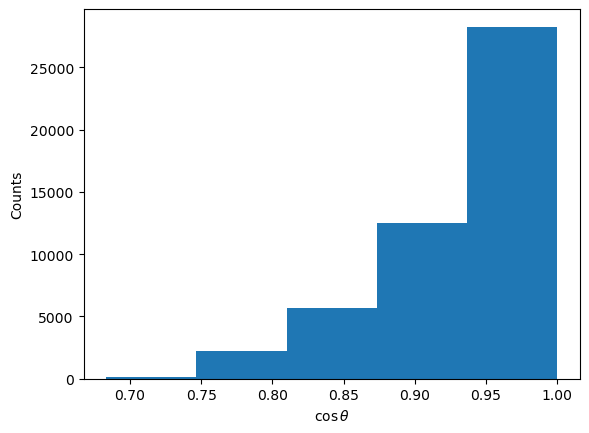

In [15]:
# Plot theta histogram
plt.hist(np.cos(np.deg2rad(muondata["theta"])), ctheta_bins)
plt.xlabel(r'$\cos\theta$')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

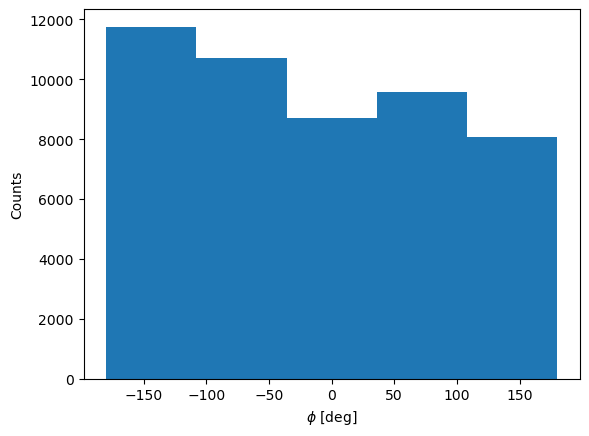

In [16]:
# Plot phi histogram
plt.hist(muondata["phi"], phi_bins)
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

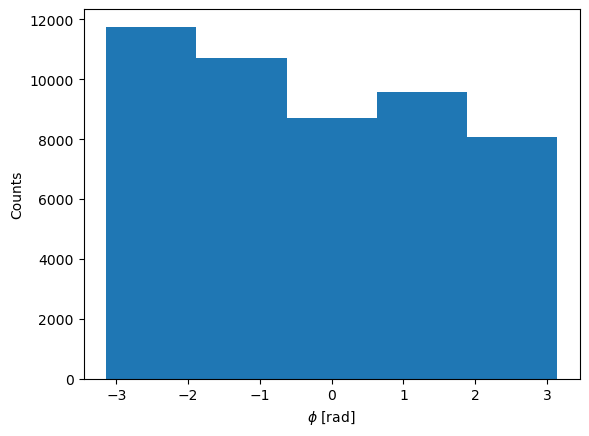

In [17]:
plt.hist(np.deg2rad(muondata["phi"]), np.deg2rad(phi_bins))
plt.xlabel(r'$\phi$ [rad]')
plt.ylabel('Counts')

Text(0, 0.5, '$\\phi$ [deg]')

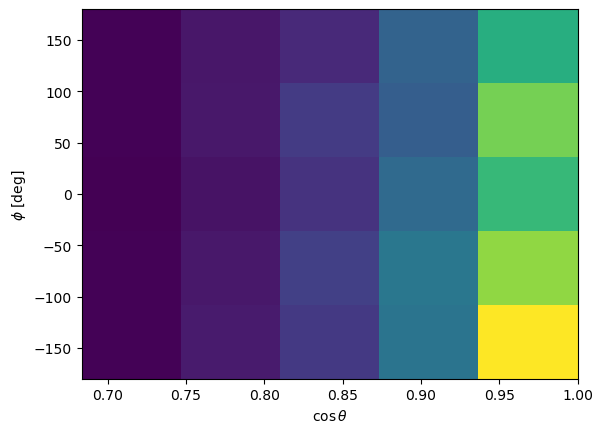

In [18]:
plt.hist2d(np.cos(np.deg2rad(muondata["theta"])), muondata["phi"], bins=n_bins)
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$\phi$ [deg]')


## Calcolo del flusso angolare
Seguiamo la formula
$$
    \Phi(\theta,\phi)=\frac{N(\theta,\phi)}{T_{\rm obs}A_{\rm eff}(\theta,\phi)\Delta\Omega}
$$
dove $N$ è il numero di conteggi, $T_{\rm obs}$ è il tempo di osservazione, $A_{\rm eff}$ è l'area efficace (vedere il notebook dedicato) e $\Delta\Omega=\Delta\cos\theta\Delta\phi$ è l'elemento di angolo solido considerato. Assumendo un errore poissoniano sui conteggi, l'errore sul flusso sarà dato da
$$
    \Delta\Phi(\theta,\phi)=\frac{\sqrt{N(\theta,\phi)}}{T_{\rm obs}A_{\rm eff}(\theta,\phi)\Delta\Omega}
$$

Calcoliamo ora il flusso in bin di $\phi$ e $\cos\theta$:

In [19]:
dctheta = np.diff(ctheta_bins)[0]
dphi = np.diff(np.deg2rad(phi_bins))[0]
ctheta_center = ctheta_bins[:-1] + dctheta/2
phi_center = np.deg2rad(phi_bins[:-1]) + dphi/2

In [20]:
domega = dctheta*dphi

Calcoliamo il tempo di osservazione dalla tabella dei dati:

In [21]:
if crc_ver == '2.4':
    times = muondata["Time"].astype('float')
    t = max(times) - min(times)
    print('Tempo di osservazione:', t, 's')
elif crc_ver == '2.10':
    datetimes = [datetime.strptime(d+' '+t+' '+ p, '%d/%m/%Y %I:%M:%S.%f %p') for (d,t,p) in zip(muondata["Date"], muondata["Time"], muondata["AM/PM"])]
    t = (max(datetimes) - min(datetimes)).total_seconds()
    print('Tempo di osservazione:', t, 's', f'({t/3600.:.2f} h)')

Tempo di osservazione: 35770.767 s (9.94 h)


Per l'area efficace, definiamo la funzione apposita, specificando le dimensioni del cubo e il numero dei piani di trigger:

In [22]:
L = 24
dz = 8
n = 4
def aeff(L, n, dz, theta, phi):
    # Fold phi in [0, pi/4] range
    if phi < 0 or phi > np.pi/4:
        phi_original = phi
        phi = phi % (np.pi/2)             # Wrap into [0, pi/2]
        phi = min(phi, np.pi/2 - phi)     # Fold into [0, pi/4]
        
    # Check if theta < theta_max
    if n == 1:
        th_max = np.pi/2
    else:
        th_max = np.arctan(L/((n-1)*dz*np.cos(phi)))
    if theta > th_max:
        raise ValueError(f'theta = {theta} > {th_max} for phi = {phi}')

    # If no errors, compute and return effective area
    term_1 = (L**2/np.cos(phi) - (n-1)*L*dz*np.tan(theta))*(1-np.tan(phi))
    term_2 = (L**2/np.cos(phi)**2 + (n-1)**2*dz**2*np.tan(theta)**2 - 2*(n-1)/np.cos(phi)*L*dz*np.tan(theta))*np.sin(phi)
    a = (term_1 + term_2)*np.cos(phi)*np.cos(theta)
    return a

**Nota bene:** 

Il calcolo dell'area efficace (v. `effective_area.ipynb`) è stato effettuato considerando un rivelatore con piani di spessore nullo separati da una distanza $\Delta z$, da cui dipende il massimo valore di $\theta$ per cui l'area efficace si annulla. Tuttavia, come è facilmente intuibile, nel caso in cui lo spessore dei piani non sia trascurabile questo valore massimo cambia ed è leggermente maggiore rispetto a quello calcolato nel caso di spessore nullo. Da questo fatto segue che se si prova a usare lo stesso valore di $\Delta z$ per ricostruire le tracce (considerando lo spessore dei piani) e per calcolare l'area efficace, ci possono essere alcuni valori ricostruiti di $\theta$ superiori al massimo teorico, che danno luogo a valori dell'area efficace negativi o comunque errati. 

In primissima approssimazione si può aggirare questo problema considerando un $\Delta z$ leggermente inferiore nel calcolo dell'area efficace. In questo modo i valori di $\theta$ vengono ricostruiti abbastanza correttamente (confrontare i valori dei coseni con quelli riportati dall'app...), e quelli più "estremi" vengono inclusi considerando un rivelatore con un'accettanza leggermente superiore a quella prevista teoricamente.

 Abbiamo quindi tutti gli elementi per calcolare il flusso in funzione di $\theta$ e $\phi$:

In [23]:
flux = np.array([[None for _ in ctheta_center] for _ in phi_center])
dflux = np.array([[None for _ in ctheta_center] for _ in phi_center])

In [24]:
for (i,cth) in enumerate(ctheta_center):
    for (j,ph) in enumerate(phi_center):
        th = np.acos(cth)
        a = aeff(L, n, dz, th, ph)
        flux[i,j] = counts[i,j]/(t*a*domega)
        dflux[i,j] = np.sqrt(counts[i,j])/(t*a*domega)

Calcoliamo quindi il flusso integrato su $\phi$, in modo tale da ottenere la dipendenza da $\theta$. Con un abuso di notazione definiamo
$$
    \Phi(\theta)=\int_{-\pi}^{\pi}\Phi(\theta,\phi)\,{\rm d}\phi=\sum_i\Phi(\theta,\phi_i)\Delta\phi
$$
L'errore si ottiene dalla somma in quadratura:
$$
    \Delta\Phi(\theta)=\sqrt{\sum_i\left(\Delta\Phi(\theta,\phi_i)\Delta\phi\right)^2}
$$

In [25]:
flux_theta = np.sum(flux, axis=1)*dphi
dflux_theta = [np.sqrt(x)*dphi for x in np.sum(dflux**2, axis=1)]

Per finire, adattiamo una funzione del tipo $p_0+p_1\cos^2\theta$ ai valori misurati di $\Phi(\theta)$: 

In [26]:
from scipy.optimize import curve_fit
def model(ctheta, p0, p1):
    return p0 + p1 * ctheta**2

popt, pcov = curve_fit(model, ctheta_center, flux_theta, sigma=dflux_theta)
p0, p1 = popt

ctheta_fit = np.linspace(0, 1, 1000)
y_fit = model(ctheta_fit, *popt)

In [27]:
popt

array([-0.02965013,  0.06528678])

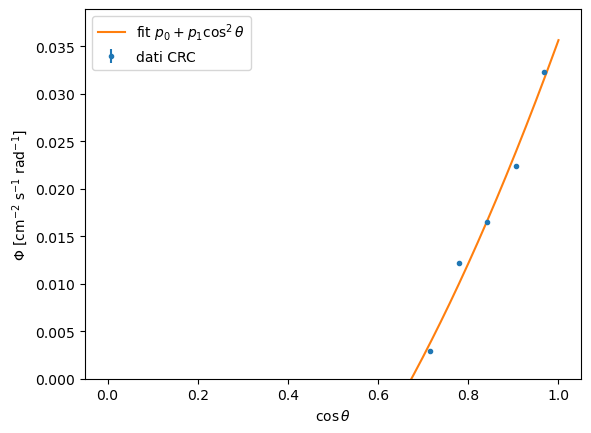

In [28]:
plt.errorbar(ctheta_center, flux_theta, yerr=dflux_theta, marker='.', label='dati CRC', linestyle='none')
# plt.errorbar(theta_center, flux_theta, yerr=dflux_theta, marker='.', label='dati CRC')
plt.plot(ctheta_fit, y_fit, label=r'fit $p_0 + p_1\cos^2\theta$')
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$\Phi$ [cm$^{-2}$ s$^{-1}$ rad$^{-1}$]')
plt.ylim(bottom=0)
plt.legend()

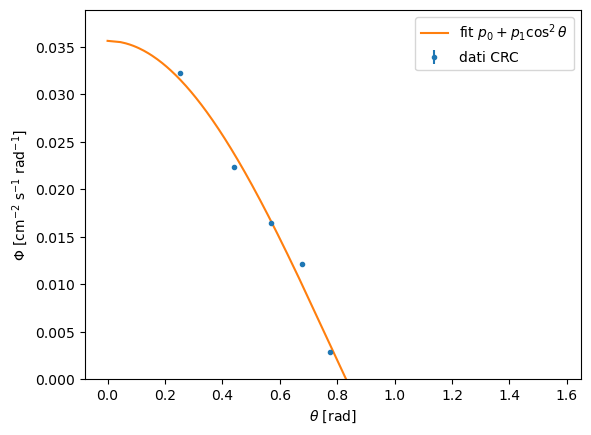

In [29]:
plt.errorbar(np.acos(ctheta_center), flux_theta, yerr=dflux_theta, marker='.', label='dati CRC', linestyle='none')
# plt.errorbar(theta_center, flux_theta, yerr=dflux_theta, marker='.', label='dati CRC')
plt.plot(np.acos(ctheta_fit), p0 + p1*ctheta_fit**2, label=r'fit $p_0 + p_1\cos^2\theta$')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\Phi$ [cm$^{-2}$ s$^{-1}$ rad$^{-1}$]')
plt.ylim(bottom=0)
plt.legend()